In [1]:
#################################           Load libs                      #############################################
import os
import numpy as np
import pandas as pd
from tensorflow.keras import callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

from ts_rnn.ts_rnn_model import TS_RNN
from ts_rnn.utils import metrics_eval, train_test_pred_plot

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Univariate prediction

In [2]:
# Import targets
target = pd.read_csv("../data/series_g.csv", sep=";").series_g.values

traget_scaler = MinMaxScaler(feature_range=(0, 1))
target_std = traget_scaler.fit_transform(target.reshape(-1, 1))

In [3]:
y_train, y_test = train_test_split(target_std, test_size=12, shuffle=False)

configs ={"model": {
            "layers": [
                {
                    "type": "LSTM",
                    "neurons": 64,
                    "return_sequences": True,
                    "activation":"linear",
                },
                 {
                    "type": "Dropout",
                    "rate": 0.2
                },
                {
                    "type": "GRU",
                    "neurons": 64,
                    "return_sequences": False,
                    "activation":"linear",
                },
                {
                    "type": "Dense",
                    "activation": "linear"
                }
            ]
        }}

In [4]:
model = TS_RNN(configs=configs,
              n_step_in=12,
              n_step_out=len(y_test),
              test_len=len(y_test),
              loss="mae",
              optimizer="adam"
             )
model.model.summary()

[Model] Model Compiled
Time taken: 0:00:00.265061
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 64)            16896     
_________________________________________________________________
dropout (Dropout)            (None, 12, 64)            0         
_________________________________________________________________
gru (GRU)                    (None, 64)                24960     
_________________________________________________________________
dense (Dense)                (None, 12)                780       
Total params: 42,636
Trainable params: 42,636
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Create folder for reports
try:
    os.chdir("../reports")
except:
    os.makedirs("../reports")
    os.chdir("../reports")
new_folder_num = str(len(os.listdir()) + 1)
new_folder = "%s/%s" % ("../reports", new_folder_num)
os.mkdir(new_folder)

[Model] Training Started
[Model] 100 epochs, 12 batch size
Epoch 1/100
10/10 - 5s - loss: 0.2674 - val_loss: 0.4070
Epoch 2/100
10/10 - 0s - loss: 0.0898 - val_loss: 0.1110
Epoch 3/100
10/10 - 0s - loss: 0.1147 - val_loss: 0.1546
Epoch 4/100
10/10 - 0s - loss: 0.0843 - val_loss: 0.1133
Epoch 5/100
10/10 - 0s - loss: 0.0700 - val_loss: 0.1067
Epoch 6/100
10/10 - 0s - loss: 0.0709 - val_loss: 0.1083
Epoch 7/100
10/10 - 0s - loss: 0.0706 - val_loss: 0.1099
Epoch 8/100
10/10 - 0s - loss: 0.0670 - val_loss: 0.1066
Epoch 9/100
10/10 - 0s - loss: 0.0650 - val_loss: 0.1074
Epoch 10/100
10/10 - 0s - loss: 0.0671 - val_loss: 0.1098
Epoch 11/100
10/10 - 0s - loss: 0.0689 - val_loss: 0.1101
Epoch 12/100
10/10 - 0s - loss: 0.0653 - val_loss: 0.1124
Epoch 13/100
10/10 - 0s - loss: 0.0703 - val_loss: 0.1063
Epoch 14/100
10/10 - 0s - loss: 0.0685 - val_loss: 0.1082
Epoch 15/100
10/10 - 0s - loss: 0.0641 - val_loss: 0.1052
Epoch 16/100
10/10 - 0s - loss: 0.0645 - val_loss: 0.1055
Epoch 17/100
10/10 - 0

/opt/anaconda3/envs/TS_RNN/lib/python3.7/site-packages/scikit_learn-0.24.1-py3.7-macosx-10.9-x86_64.egg/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/levperla/PycharmProjects/Time_Series_Prediction_RNN/ts_rnn/utils.py:71: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('{}.{}'.format(name, fmt), fmt='png')


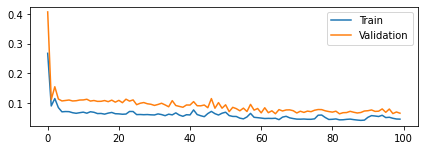

In [6]:
my_callbacks = [callbacks.EarlyStopping(patience=30, monitor='val_loss')]

model.fit(target=target_std,
          epochs=100,
          batch_size=12,
          callbacks=my_callbacks,
          save_dir=new_folder,
          verbose=2)

Mean Absolute Error: 13.404
Mean Squared Error: 275.959
Root Mean Squared Error: 16.612
Mean absolute percentage error: 2.953
Scaled Mean absolute percentage error: 2.995


/Users/levperla/PycharmProjects/Time_Series_Prediction_RNN/ts_rnn/utils.py:71: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('{}.{}'.format(name, fmt), fmt='png')
/Users/levperla/PycharmProjects/Time_Series_Prediction_RNN/ts_rnn/utils.py:71: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('{}.{}'.format(name, fmt), fmt='png')


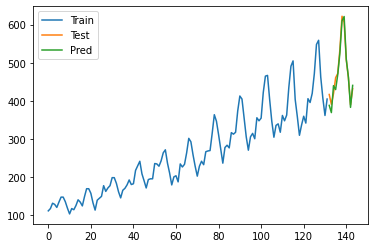

In [7]:
predicted = model.predict(target=y_train[-model.n_step_in:], prediction_len=len(y_test))

# inverse transform
y_train = traget_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test = traget_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
predicted = traget_scaler.inverse_transform(predicted.reshape(-1, 1)).flatten()

metrics_eval(y_test, predicted, print_result=True, save_dir=new_folder)
train_test_pred_plot(train=y_train, test=y_test, predicted=predicted, save_dir=new_folder)

## Mulrivariate prediction (Target + Factors)

In [8]:
# Import targets
target = pd.read_csv("../data/series_g.csv", sep=";").series_g.values

# Generate factors
f1 = np.arange(1, len(target) + 1).reshape(-1, 1)
f2 = (np.arange(1, len(target) + 1) ** 2).reshape(-1, 1)
factors = np.hstack((f1, f2))

traget_scaler = MinMaxScaler(feature_range=(0, 1))
factors_scaler = MinMaxScaler(feature_range=(0, 1))

target_std = traget_scaler.fit_transform(target.reshape(-1, 1))
factors_std = factors_scaler.fit_transform(factors)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(factors_std, target_std, test_size=12, random_state=42, shuffle=False)

configs ={"model": {
            "layers": [
                {
                    "type": "LSTM",
                    "neurons": 128,
                    "return_sequences": False
                },
                {
                    "type": "Dropout",
                    "rate": 0.2
                },
                {
                    "type": "Dense",
                    "activation": "linear"
                }
            ]
        }}

In [10]:
model = TS_RNN(configs=configs,
              n_step_in=12,
              n_step_out=len(y_test),
              test_len=len(y_test),
              loss="mae",
              optimizer="adam",
              n_features=X_train.shape[1]  # also you need to define this if use factors
             )
model.model.summary()

[Model] Model Compiled
Time taken: 0:00:00.113424
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               67584     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1548      
Total params: 69,132
Trainable params: 69,132
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Create folder for reports
try:
    os.chdir("../reports")
except:
    os.makedirs("../reports")
    os.chdir("../reports")
new_folder_num = str(len(os.listdir()) + 1)
new_folder = "%s/%s" % ("../reports", new_folder_num)
os.mkdir(new_folder)

[Model] Training Started
[Model] 100 epochs, 12 batch size
Epoch 1/100
10/10 - 2s - loss: 0.1880 - val_loss: 0.1772
Epoch 2/100
10/10 - 0s - loss: 0.1074 - val_loss: 0.1510
Epoch 3/100
10/10 - 0s - loss: 0.0917 - val_loss: 0.1206
Epoch 4/100
10/10 - 0s - loss: 0.0782 - val_loss: 0.1176
Epoch 5/100
10/10 - 0s - loss: 0.0812 - val_loss: 0.1178
Epoch 6/100
10/10 - 0s - loss: 0.0745 - val_loss: 0.1124
Epoch 7/100
10/10 - 0s - loss: 0.0742 - val_loss: 0.1091
Epoch 8/100
10/10 - 0s - loss: 0.0733 - val_loss: 0.1108
Epoch 9/100
10/10 - 0s - loss: 0.0714 - val_loss: 0.1121
Epoch 10/100
10/10 - 0s - loss: 0.0718 - val_loss: 0.1073
Epoch 11/100
10/10 - 0s - loss: 0.0698 - val_loss: 0.1061
Epoch 12/100
10/10 - 0s - loss: 0.0716 - val_loss: 0.1110
Epoch 13/100
10/10 - 0s - loss: 0.0698 - val_loss: 0.1096
Epoch 14/100
10/10 - 0s - loss: 0.0695 - val_loss: 0.1074
Epoch 15/100
10/10 - 0s - loss: 0.0690 - val_loss: 0.1083
Epoch 16/100
10/10 - 0s - loss: 0.0691 - val_loss: 0.1069
Epoch 17/100
10/10 - 0

/opt/anaconda3/envs/TS_RNN/lib/python3.7/site-packages/scikit_learn-0.24.1-py3.7-macosx-10.9-x86_64.egg/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/levperla/PycharmProjects/Time_Series_Prediction_RNN/ts_rnn/utils.py:71: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('{}.{}'.format(name, fmt), fmt='png')


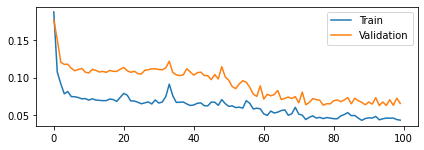

In [12]:
my_callbacks = [callbacks.EarlyStopping(patience=30, monitor='val_loss')]

model.fit(factors=factors_std,  # also you need to define this if use factors
          target=target_std,
          epochs=100,
          batch_size=12,
          callbacks=my_callbacks,
          save_dir=new_folder,
          verbose=2)

/opt/anaconda3/envs/TS_RNN/lib/python3.7/site-packages/scikit_learn-0.24.1-py3.7-macosx-10.9-x86_64.egg/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/levperla/PycharmProjects/Time_Series_Prediction_RNN/ts_rnn/utils.py:71: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('{}.{}'.format(name, fmt), fmt='png')
/Users/levperla/PycharmProjects/Time_Series_Prediction_RNN/ts_rnn/utils.py:71: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('{}.{}'.format(name, fmt), fmt='png')


Mean Absolute Error: 24.847
Mean Squared Error: 752.6
Root Mean Squared Error: 27.434
Mean absolute percentage error: 5.274
Scaled Mean absolute percentage error: 5.358


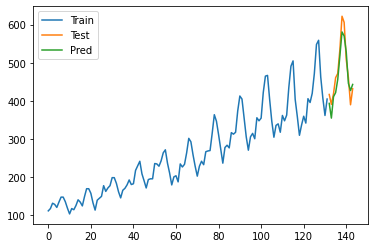

In [13]:
predicted = model.predict(
    factors=X_train[-model.n_step_in:],  # also you need to define this if use factors
    target=y_train[-model.n_step_in:],
    prediction_len=len(y_test)
)

# inverse transform
y_train = traget_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test = traget_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
predicted = traget_scaler.inverse_transform(predicted.reshape(-1, 1)).flatten()


metrics_eval(y_test, predicted, print_result=True, save_dir=new_folder)
train_test_pred_plot(train=y_train, test=y_test, predicted=predicted, save_dir=new_folder)